เราจะจำแนก รูปภาพแบบหลายหมวดหมู่ โดยใช้ภาพถ่ายจากดาวเทียบ


# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. ข้อมูล

Download จาก Kaggle


In [3]:
# ! {sys.executable} -m pip install kaggle --upgrade

* สมัคร Kaggle
* เข้าหน้า My Account
* ในหมวด API กดปุ่ม <kbd>Create New API Token</kbd>
* Download ไฟล์ kaggle.json
* เปิด Jupyter Notebook Dashboard ไปอัพโหลดไฟล์ไว้ใน path ปัจจุบัน




In [4]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/


1. เปิดหน้าเว็บการแข่งขัน Kaggle [Planet: Understanding the Amazon from Space Competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)
2. เข้าไปกด Join การแข่งขัน กด Accept กติกา 
3. Uncomment แล้ว Run โค้ดด้านล่างเพื่อ Download ชุดข้อมูล

In [5]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

Install โปรแกรม 7zip สำหรับแตกไฟล์ นามสกุล .7z

In [6]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

แตกไฟล์รูป train-jpg.tar.7z

In [7]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Label อยู่ในไฟล์ csv ##


In [8]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [9]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/planet/train_v2.csv'),
 PosixPath('/home/jupyter/.fastai/data/planet/models'),
 PosixPath('/home/jupyter/.fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/__MACOSX'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg.tar.7z')]

สังเกตว่า Label อยู่ในไฟล์ csv และ tags บอกหมวดหมู่ รูปหนึ่งรูปอยู่หลายหมวดหมู่ คั่นด้วย " " (space)

In [10]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


ดึงรายชื่อไฟล์จาก path_images และแสดงรายการ 10 ไฟล์แรก

In [11]:
path_images = path/'train-jpg'
filenames = get_image_files(path_images)
filenames[:10]

[PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_1424.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_27978.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_24420.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_887.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_31571.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_9438.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_22505.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_26308.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_950.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_33612.jpg')]

# 3. เตรียมข้อมูล

กกกก

In [12]:
batchsize = 32
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [13]:
np.random.seed(42)
datasource = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

size = 128 x 128 Pixel

In [14]:
imagesize = 128
databunch = (datasource.transform(tfms, size=128)
        .databunch(bs=batchsize).normalize(imagenet_stats))

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

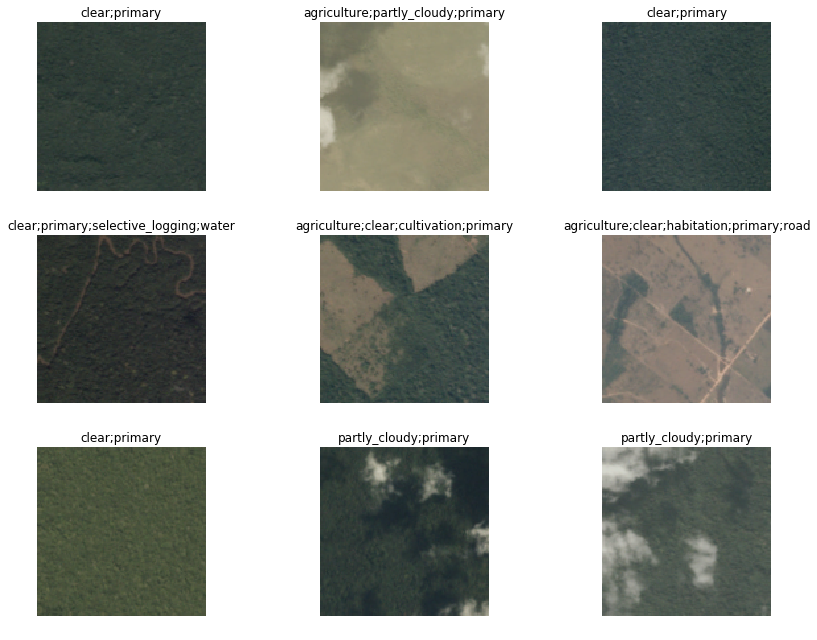

In [15]:
databunch.show_batch(rows=3, figsize=(12,9))

 รูปหนึ่งรูปสามารถเป็น จำแนกได้เป็น ถนน พื้นที่เพาะปลูก มีบังบางส่วน

In [16]:
databunch.classes, databunch.c, len(databunch.train_ds), len(databunch.valid_ds)

(['agriculture',
  'artisinal_mine',
  'bare_ground',
  'blooming',
  'blow_down',
  'clear',
  'cloudy',
  'conventional_mine',
  'cultivation',
  'habitation',
  'haze',
  'partly_cloudy',
  'primary',
  'road',
  'selective_logging',
  'slash_burn',
  'water'],
 17,
 32384,
 8095)

# 4. สร้างโมเดล



F beta  และ accuracy_thresh 0.2


In [17]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [18]:
learner = cnn_learner(databunch, models.resnet50, 
                      metrics=[acc_02, f_score], 
                      callback_fns=ShowGraph).to_fp16()

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 8 Epoch

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.136824,0.119283,0.941562,0.895304,01:16
1,0.119758,0.103721,0.948770,0.908763,01:13
2,0.108189,0.098215,0.949141,0.912460,01:13
3,0.101791,0.094684,0.957425,0.918235,01:14
4,0.102984,0.091457,0.956720,0.923087,01:13
5,0.100877,0.089671,0.956044,0.923700,01:14
6,0.095518,0.088967,0.956661,0.923657,01:13
7,0.090439,0.088803,0.955718,0.923363,01:13


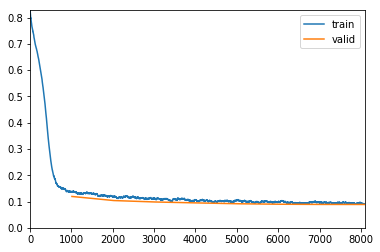

In [19]:
learner.fit_one_cycle(8)

เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [20]:
learner.save('03a-resnet50-1')

โหลดโมเดลที่เรา Save ไว้ ขึ้นมาใหม่ เตรียมเทรนในขึ้นตอนถัดไป (ที่คอมเม้นท์ไว้ เพราะถ้าไม่ได้เปลี่ยนอะไรก็จะได้ไม่ต้องรัน)

In [21]:
# learner.load('03a-resnet50-1')

# 6. เทรนต่อ

unfreeze layer ทุก Layer ให้สามารถเทรนได้ แล้วเทรนต่อทั้งโมเดล

In [22]:
learner.unfreeze()
# learner.lr_find()
# learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097384,0.089868,0.958152,0.923907,01:49
1,0.097207,0.089321,0.957272,0.923194,01:49
2,0.095337,0.087045,0.957716,0.923951,01:49
3,0.089807,0.086164,0.958057,0.926010,01:49
4,0.084950,0.085168,0.958748,0.927146,01:49
5,0.081621,0.085612,0.959489,0.927272,01:49


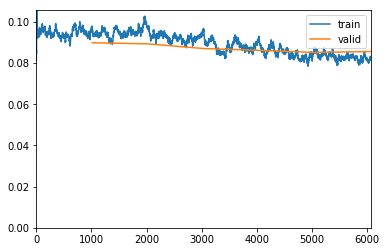

In [23]:
learner.fit_one_cycle(6, max_lr=slice(3e-6,3e-4))

In [24]:
learner.save('03a-resnet50-2')

In [25]:
# learner.load('03a-resnet50-2')

# 7. เทรนต่อ 2

Transfer Learning โมเดลที่เราเพิ่งเทรนเสร็จ นำมาเทรนต่อด้วย Data ทีรูปใหญ่ขึ้น เป็น 256 x 256 Pixel

In [26]:
imagesize = 256
databunch = (datasource.transform(tfms, size=imagesize)
        .databunch(bs=batchsize).normalize(imagenet_stats))

learner.data = databunch
databunch.train_ds[0][0].shape

torch.Size([3, 256, 256])

Freeze ใหม่ เพื่อเทรนเฉพาะ Layer สุดท้าย

In [31]:
learner.to_fp16().freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.093276,0.090830,0.955325,0.920761,02:57
1,0.098166,0.089773,0.956116,0.920365,02:54
2,0.091720,0.084977,0.957941,0.925967,02:54
3,0.085043,0.082784,0.959925,0.928632,02:53
4,0.087392,0.081521,0.958892,0.929890,02:53


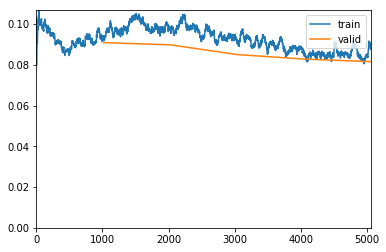

In [32]:
learner.fit_one_cycle(5, 3e-3)

In [34]:
learner.save('03a-resnet50-256-1')

In [36]:
# learner.load('03a-resnet50-256-1')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085826,0.082419,0.957715,0.928818,04:05
1,0.088903,0.083869,0.958544,0.927162,04:04
2,0.086310,0.082489,0.959001,0.930131,04:04
3,0.078504,0.081895,0.959510,0.928885,04:04
4,0.081221,0.081772,0.960782,0.929764,04:04


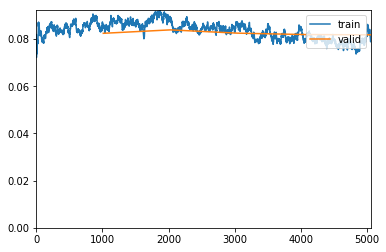

In [37]:
learner.unfreeze()
learner.fit_one_cycle(5, slice(3e-6, 3e-4))

## สำเร็จแล้ว ##

ฟฟฟฟฟ


เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [38]:
learner.save('03a-resnet50-256-2')

In [39]:
# learner.load('03a-resnet50-256-2')

In [40]:
learner.export()

# 7. ดูผลลัพธ์

In [43]:
interpretation = ClassificationInterpretation.from_learner(learner.to_fp32())

## โมเดลจำแนกผิวได้ถูกต้อง

สั่งให้ plot_top_losses คือ แสดง record ที่ ค่า loss น้อยที่สุด หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายถูกต้อง 9 อันดับแรก โดยมีการแสดง heat map สีแดง ให้ดูด้วยว่า model พิจารณาเน้นจากส่วนไหนของรูปเป็นหลัก เรียกว่า Attention ที่ไว้เราจะอธิบายต่อไป

IndexError: index 87857 is out of bounds for axis 0 with size 8095

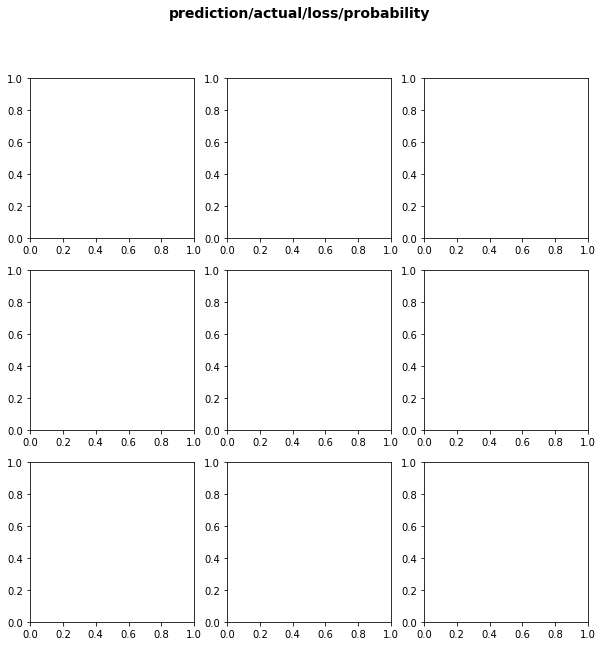

In [44]:
interpretation.plot_top_losses(9, figsize=(10,10), largest=False)

จะเห็นได้ว่าโมเดลพิจารณาถูกจุดจริง ๆ โฟกัสตรงตำแหน่ง

## โมเดลจำแนก ผิดหมวด

สั่งให้ plot_top_losses คือ แสดง record ที่ ค่า loss มากที่สุด หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายผิด 9 อันดับแรก 

In [ ]:
interpretation.plot_top_losses(9, figsize=(10,10), largest=True)

จะเห็นได้ว่า...

# 8. ส่งประกวด

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
# test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
# len(test)

In [ ]:
# learner = load_learner(path, test=test)
# preds, _ = learner.get_preds(ds_type=DatasetType.Test)

In [ ]:
# thresh = 0.2
# labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
# labelled_preds[:5]

In [ ]:
# fnames = [f.name[:-4] for f in learn.data.test_ds.items]
# df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
# df.to_csv(path/'submission.csv', index=False)

In [ ]:
# ! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

# 9. สรุป


# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 3](https://course.fast.ai/videos/?lesson=3)